# Local quadratic acq model 2024-09

This notebook defines a "local quadratic" acquisition probability model.

For each point on 3-d grid of `mag`, `t_ccd` and `halfwidth`, this model fits a
hyper-paraboloid to nearby data (within +/- 2 grid points inclusive)::

    dmag = mag - mag0
    dt_ccd = t_ccd - t_ccd0
    dhalfwdith = halfwidth - halfwidth0

    p_probit = (
        p0 * dmag + p1 * dmag**2 
        + p2 * dt_ccd + p3 * dt_ccd**2
        + p4 * dhalfwidth + p5 * dhalfwidth**2
        + p6
    )

The 3-d grid of points is defined by the sampling in the 2022-Dec ASVT test data::

    mag       : 8.  9.  9.5  9.75 10.  10.25 10.5  10.75 (mag)
    t_ccd     : -15 -13 -11  -9  -8  -7  -6  -5  -4  -3  -2  0  2 (degC)
    halfwidth : 60  80 100 120 140 160 (arcsec)

This uses the 2024-Sep ASVT data set with MAXMAG clipped along with flight data
from 2019-July-01 (approx start time of MAXMAG clipping in flight products).

Reference page:
https://occweb.cfa.harvard.edu/twiki/bin/view/Aspect/PeaAcqModelCalDec2022Testing

In [1]:
import sys
import os

sys.path.insert(0, os.path.expanduser("~/git/chandra_aca"))

from pathlib import Path
from collections import Counter
import itertools
import warnings

import numpy as np
from scipy import stats
from scipy.stats import binom
from scipy import optimize
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
from matplotlib import patches
import tables
from cxotime import CxoTime
from chandra_aca import star_probs
import agasc
from chandra_aca.star_probs import binomial_confidence_interval as binom_conf
import matplotlib.style

from utils_stats import (
    flatten_pea_test_data,
    read_twiki_csv,
    get_acq_stats_data,
    get_samples_successes,
)

matplotlib.style.use("bmh")
%matplotlib inline

In [2]:
SKA = Path(os.environ["SKA"])
MODEL_DATE = "2024-09"

In [3]:
AXIS_LABELS = ["mag", "t_ccd", "halfwidth"]

In [4]:
# Read the 2022:236 data from the TWiki

dat8 = Table.read(
    "PEA_SW_TS_Acq_results_2024_08_27_w_more flight_like_maxmag.csv", format="ascii.csv"
)

In [5]:
# Convert to a format that is more convenient for analysis

asvt = flatten_pea_test_data(dat8)
# Rename to conventions of acq stats database
asvt.rename_column("Mag_sim_info", "mag_aca")
asvt.rename_column("ccd_temp", "t_ccd")
asvt.rename_column("search_success", "obc_id")
asvt.rename_column("search_box_hw", "halfwidth")
# Coerce uint8 columns (which are all actually bool) to bool
asvt["obc_id"] = asvt["obc_id"].astype(bool)
asvt.info

<Table length=69024>
           name            dtype  n_bad
------------------------- ------- -----
                Int_Cycle   int64     0
                   ID_str   str22     0
               Rows_to_Go   int64     0
                Cmd_Count   int64     0
            Int_Time_16ms   int64     0
          Num_Search_Hits   int64     0
   CalTemp_one_256th_degC   int64     0
             High_Bg_flag   int64     0
Cmd_Group_Cksum_Fail_flag   int64     0
          Proc_Reset_flag   int64     0
          Syntax_Err_flag   int64     0
                  Rec_Num   int64     0
                  Img_Fcn   int64     0
            Corner_Row_px   int64     0
            Corner_Col_px   int64     0
               Mag_scaled   int64     0
              Yang_scaled   int64     0
              Zang_scaled   int64     0
                  SP_Flag   int64     0
                  DP_Flag   int64     0
                  QB_Flag   int64     0
                  CC_Flag   int64     0
                  M

In [6]:
# Read flight acquisition stats data and remove color=1.5 stars that have a different
# acquisition model due to a different mag error distribution.
flt = get_acq_stats_data()

In [7]:
CxoTime(np.min(flt["tstart"])).date

'2019:182:04:51:25.240'

In [8]:
flt.info

<Table length=86354>
   name    dtype 
--------- -------
   tstart float64
    obsid   int64
   obc_id    bool
halfwidth   int64
  mag_aca float32
  mag_obs float64
    color float32
 img_func  bytes7
  ion_rad    bool
  sat_pix    bool
 agasc_id   int64
    t_ccd float64
     slot   int64
mag_catid    bool
     year float32
  quarter float32

In [9]:
set(flt["mag_catid"])

{True}

In [10]:
# Combine the ASVT and flight data, taking only common columns
flt_asvt = vstack([flt, asvt], join_type="inner")
flt_asvt = asvt
flt_asvt.info

<Table length=69024>
           name            dtype  n_bad
------------------------- ------- -----
                Int_Cycle   int64     0
                   ID_str   str22     0
               Rows_to_Go   int64     0
                Cmd_Count   int64     0
            Int_Time_16ms   int64     0
          Num_Search_Hits   int64     0
   CalTemp_one_256th_degC   int64     0
             High_Bg_flag   int64     0
Cmd_Group_Cksum_Fail_flag   int64     0
          Proc_Reset_flag   int64     0
          Syntax_Err_flag   int64     0
                  Rec_Num   int64     0
                  Img_Fcn   int64     0
            Corner_Row_px   int64     0
            Corner_Col_px   int64     0
               Mag_scaled   int64     0
              Yang_scaled   int64     0
              Zang_scaled   int64     0
                  SP_Flag   int64     0
                  DP_Flag   int64     0
                  QB_Flag   int64     0
                  CC_Flag   int64     0
                  M

In [11]:
def get_vals_and_bins(vals):
    """
    For a set of values, return sorted unique values and bin edges.

    Bin edges are centered on the unique values and have an extra bin
    at the start and end to cover the full range of values.
    """
    out_vals = np.array(sorted(set(vals)))
    out_val_centers = (out_vals[1:] + out_vals[:-1]) / 2
    out_val_bins = np.concatenate(
        [
            [out_vals[0] - 0.5],
            out_val_centers,
            [out_vals[-1] + 0.5],
        ]
    )
    return out_vals, out_val_bins

In [12]:
t_ccd_vals, t_ccd_bins = get_vals_and_bins(
    [-15, -13, -11, -9, -8, -7, -6, -5, -4, -3, -2, 0, 2]
)
mag_vals, mag_bins = get_vals_and_bins([8.0, 9.0, 9.5, 9.75, 10.0, 10.25, 10.5, 10.75])
halfwidth_vals, halfwidth_bins = get_vals_and_bins([60, 80, 100, 120, 140, 160])

In [13]:
X_VALS = [mag_vals, t_ccd_vals, halfwidth_vals]

In [14]:
print(star_probs.conf.default_model)


def get_flight_model_probs():
    mag_grid, t_ccd_grid, halfwidth_grid = np.meshgrid(
        mag_vals, t_ccd_vals, halfwidth_vals, indexing="ij"
    )
    p_succ_flt = star_probs.acq_success_prob(
        date="2023:001", mag=mag_grid, t_ccd=t_ccd_grid, halfwidth=halfwidth_grid
    )
    return p_succ_flt

grid-*


In [16]:
n_samp, n_succ = get_samples_successes(flt_asvt, mag_bins, t_ccd_bins, halfwidth_bins)
n_fail = n_samp - n_succ
n_samp_flt, n_succ_flt = get_samples_successes(
    flt, mag_bins, t_ccd_bins, halfwidth_bins
)
n_fail_flt = n_samp_flt - n_succ_flt
n_samp_asvt, n_succ_asvt = get_samples_successes(
    asvt, mag_bins, t_ccd_bins, halfwidth_bins
)
n_fail_asvt = n_samp_asvt - n_succ_asvt

In [17]:
n_samp.shape

(8, 13, 6)

In [18]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    p_succ_flt = get_flight_model_probs()

In [19]:
print(mag_vals)
print(mag_bins)

[ 8.    9.    9.5   9.75 10.   10.25 10.5  10.75]
[ 7.5    8.5    9.25   9.625  9.875 10.125 10.375 10.625 11.25 ]


In [20]:
print(repr(t_ccd_vals))
print(repr(t_ccd_bins))

array([-15, -13, -11,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,   0,   2])
array([-15.5, -14. , -12. , -10. ,  -8.5,  -7.5,  -6.5,  -5.5,  -4.5,
        -3.5,  -2.5,  -1. ,   1. ,   2.5])


In [21]:
print(halfwidth_vals)
print(halfwidth_bins)

[ 60  80 100 120 140 160]
[ 59.5  70.   90.  110.  130.  150.  160.5]


In [22]:
# Oddball case mag=9.5 t_ccd=-4 halfwidth=120. Big discrepancy between flight stats and
# model.
odd = (2, 8, 3)

In [23]:
print(
    n_fail_flt[odd],
    n_samp_flt[odd],
    binom_conf(n_fail_flt[odd], n_samp_flt[odd]),
)
print(
    n_fail_asvt[odd],
    n_samp_asvt[odd],
    binom_conf(n_fail_asvt[odd], n_samp_asvt[odd]),
)
print(
    n_fail[odd],
    n_samp[odd],
    binom_conf(n_fail[odd], n_samp[odd]),
)
print(
    1 - star_probs.acq_success_prob(date="2024:001", mag=9.5, t_ccd=-4, halfwidth=120)
)

13 36 (0.3611111111111111, 0.2858872207600804, 0.44392424313804624)
2 11 (0.18181818181818182, 0.0956724560588439, 0.3228438432340194)
2 11 (0.18181818181818182, 0.0956724560588439, 0.3228438432340194)
0.1470539148214507


In [24]:
binom_conf(n_samp_asvt[2, 2, 3] - n_succ_asvt[2, 2, 3], n_samp_asvt[2, 2, 3])

(0.0, 0.0, 0.1279418860066268)

In [25]:
1 - star_probs.acq_success_prob(mag=9.5, t_ccd=-11, halfwidth=120)

0.04026530820552199

In [26]:
0.015 * 36

0.54

In [27]:
ok = (
    (flt["mag_aca"] > 9.25)
    & (flt["mag_aca"] < 9.75)
    & (flt["t_ccd"] > -5)
    & (flt["halfwidth"] == 120)
)
np.count_nonzero(flt["ion_rad"][ok]) / len(flt[ok])

0.0

In [28]:
from dataclasses import dataclass


@dataclass
class ProbFail:
    p_fail: float
    p_fail_lower: float
    p_fail_upper: float
    mean_t_ccd: float
    mean_mag: float
    n_fail: int
    n_acq: int

In [29]:
def calc_binned_pfail(data, mag0, mag1, t_ccd0, t_ccd1, halfwidth=120):
    fail = ~data["obc_id"].astype(bool)
    ok = (
        (data["mag_aca"] >= mag0)
        & (data["mag_aca"] < mag1)
        & (data["t_ccd"] >= t_ccd0)
        & (data["t_ccd"] < t_ccd1)
        & (data["halfwidth"] == halfwidth)
    )
    n_fail = np.count_nonzero(fail[ok])
    n_acq = np.count_nonzero(ok)
    if n_acq < 5:
        return None
    p_fail = n_fail / n_acq
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        _, p_fail_lower, p_fail_upper = binom_conf(n_fail, n_acq)
    # Ensure that error bars are >= 0. We will want to plot p_fail as n_fail/n_acq,
    # instead of (e.g.) p_fail = 50th percentile.
    p_fail_lower = min(p_fail, p_fail_lower)
    p_fail_upper = max(p_fail, p_fail_upper)
    mean_t_ccd = np.mean(data["t_ccd"][ok])
    mean_mag = np.mean(data["mag_aca"][ok])
    out = ProbFail(
        p_fail, p_fail_lower, p_fail_upper, mean_t_ccd, mean_mag, n_fail, n_acq
    )
    return out

In [30]:
calc_binned_pfail(flt, mag0=9.25, mag1=9.75, t_ccd0=-10, t_ccd1=-8.5, halfwidth=120)

ProbFail(p_fail=0.1033210332103321, p_fail_lower=0.08628788411766172, p_fail_upper=0.12327628492561783, mean_t_ccd=-9.228375146309828, mean_mag=9.497556, n_fail=28, n_acq=271)

In [31]:
print(binom_conf(0, 286))
print(star_probs.binom_ppf(0, 200, [0.16, 0.84]))

(0.0, 0.0, 0.003464714292849523)
[0.         0.00808615]


In [32]:
get_samples_successes(
    flt, [9.25, 9.75], [-10, -8.5], [110, 130]
)  # mag_bins, t_ccd_bins, halfwidth_bins)

(array([[[271]]]), array([[[243]]]))

In [33]:
def make_plots_grid(x_axis="t_ccd", x_grid="halfwidth", y_grid="mag", plot_p_fit=True):
    idx_x_axis = AXIS_LABELS.index(x_axis)
    idx_x_grid = AXIS_LABELS.index(x_grid)
    idx_y_grid = AXIS_LABELS.index(y_grid)

    n_x_axis = n_samp.shape[idx_x_axis]
    n_x_grid = n_samp.shape[idx_x_grid]
    n_y_grid = n_samp.shape[idx_y_grid]

    size_per_plot = 2.0
    figsize = (size_per_plot * n_x_grid, size_per_plot * n_y_grid)
    from typing import Tuple

    fig, axes = plt.subplots(
        nrows=n_y_grid, ncols=n_x_grid, figsize=figsize, sharex=True, sharey=True
    )
    idxs_point = [None, None, None]

    for i_row in range(n_y_grid):
        idxs_point[idx_y_grid] = i_row

        for i_col in range(n_x_grid):
            idxs_point[idx_x_grid] = i_col
            x = X_VALS[idx_x_axis]
            y = np.empty(shape=(n_x_axis,))
            y_fit = np.empty(shape=(n_x_axis,))
            y_flt = np.empty(shape=(n_x_axis,))
            yerr = np.empty(shape=(2, n_x_axis))

            for i_x in range(n_x_axis):
                idxs_point[idx_x_axis] = i_x
                ijk = tuple(idxs_point)
                k = n_succ[ijk]
                n = n_samp[ijk]
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    _, sig_low, sig_high = binom_conf(k, n)
                p = k / n
                y[i_x] = p
                if plot_p_fit:
                    y_fit[i_x] = p_fit[ijk]
                y_flt[i_x] = p_succ_flt[ijk]
                yerr[0, i_x] = np.clip(p - sig_low, 0, None)
                yerr[1, i_x] = np.clip(sig_high - p, 0, None)

            ax = axes[i_row, i_col]
            ax.errorbar(x, y, yerr=yerr, fmt="o-", color="C0")
            if plot_p_fit:
                ax.plot(x, y_fit, "-", color="C1")
            ax.plot(x, y_flt, "--", color="C2")
            ax.set_ylim(0, 1)
            ax.text(
                0.05,
                0.05,
                f"{x_grid}={X_VALS[idx_x_grid][i_col]}",
                horizontalalignment="left",
                verticalalignment="bottom",
                transform=ax.transAxes,
                fontsize="small",
            )
            ax.text(
                0.05,
                0.15,
                f"{y_grid}={X_VALS[idx_y_grid][i_row]}",
                horizontalalignment="left",
                verticalalignment="bottom",
                transform=ax.transAxes,
                fontsize="small",
            )
            # ax.set_title(f"mag={mag_vals[i_mag]:.1f}")

    fig.subplots_adjust(hspace=0, wspace=0)
    fig.suptitle(
        f"Acq success probability vs {x_axis} "
        "(blue=ASVT + flight data, red=fit, dashed=flight model)\n"
    )
    fig.tight_layout()

/var/folders/0p/mj5zm2311gl283lksrknl7bc0000gp/T/ipykernel_45141/804818365.py:38: RuntimeWarning: invalid value encountered in scalar divide
  p = k / n
/var/folders/0p/mj5zm2311gl283lksrknl7bc0000gp/T/ipykernel_45141/804818365.py:38: RuntimeWarning: invalid value encountered in scalar divide
  p = k / n
/var/folders/0p/mj5zm2311gl283lksrknl7bc0000gp/T/ipykernel_45141/804818365.py:38: RuntimeWarning: invalid value encountered in scalar divide
  p = k / n
/var/folders/0p/mj5zm2311gl283lksrknl7bc0000gp/T/ipykernel_45141/804818365.py:38: RuntimeWarning: invalid value encountered in scalar divide
  p = k / n
/var/folders/0p/mj5zm2311gl283lksrknl7bc0000gp/T/ipykernel_45141/804818365.py:38: RuntimeWarning: invalid value encountered in scalar divide
  p = k / n
/var/folders/0p/mj5zm2311gl283lksrknl7bc0000gp/T/ipykernel_45141/804818365.py:38: RuntimeWarning: invalid value encountered in scalar divide
  p = k / n
/var/folders/0p/mj5zm2311gl283lksrknl7bc0000gp/T/ipykernel_45141/804818365.py:38: 

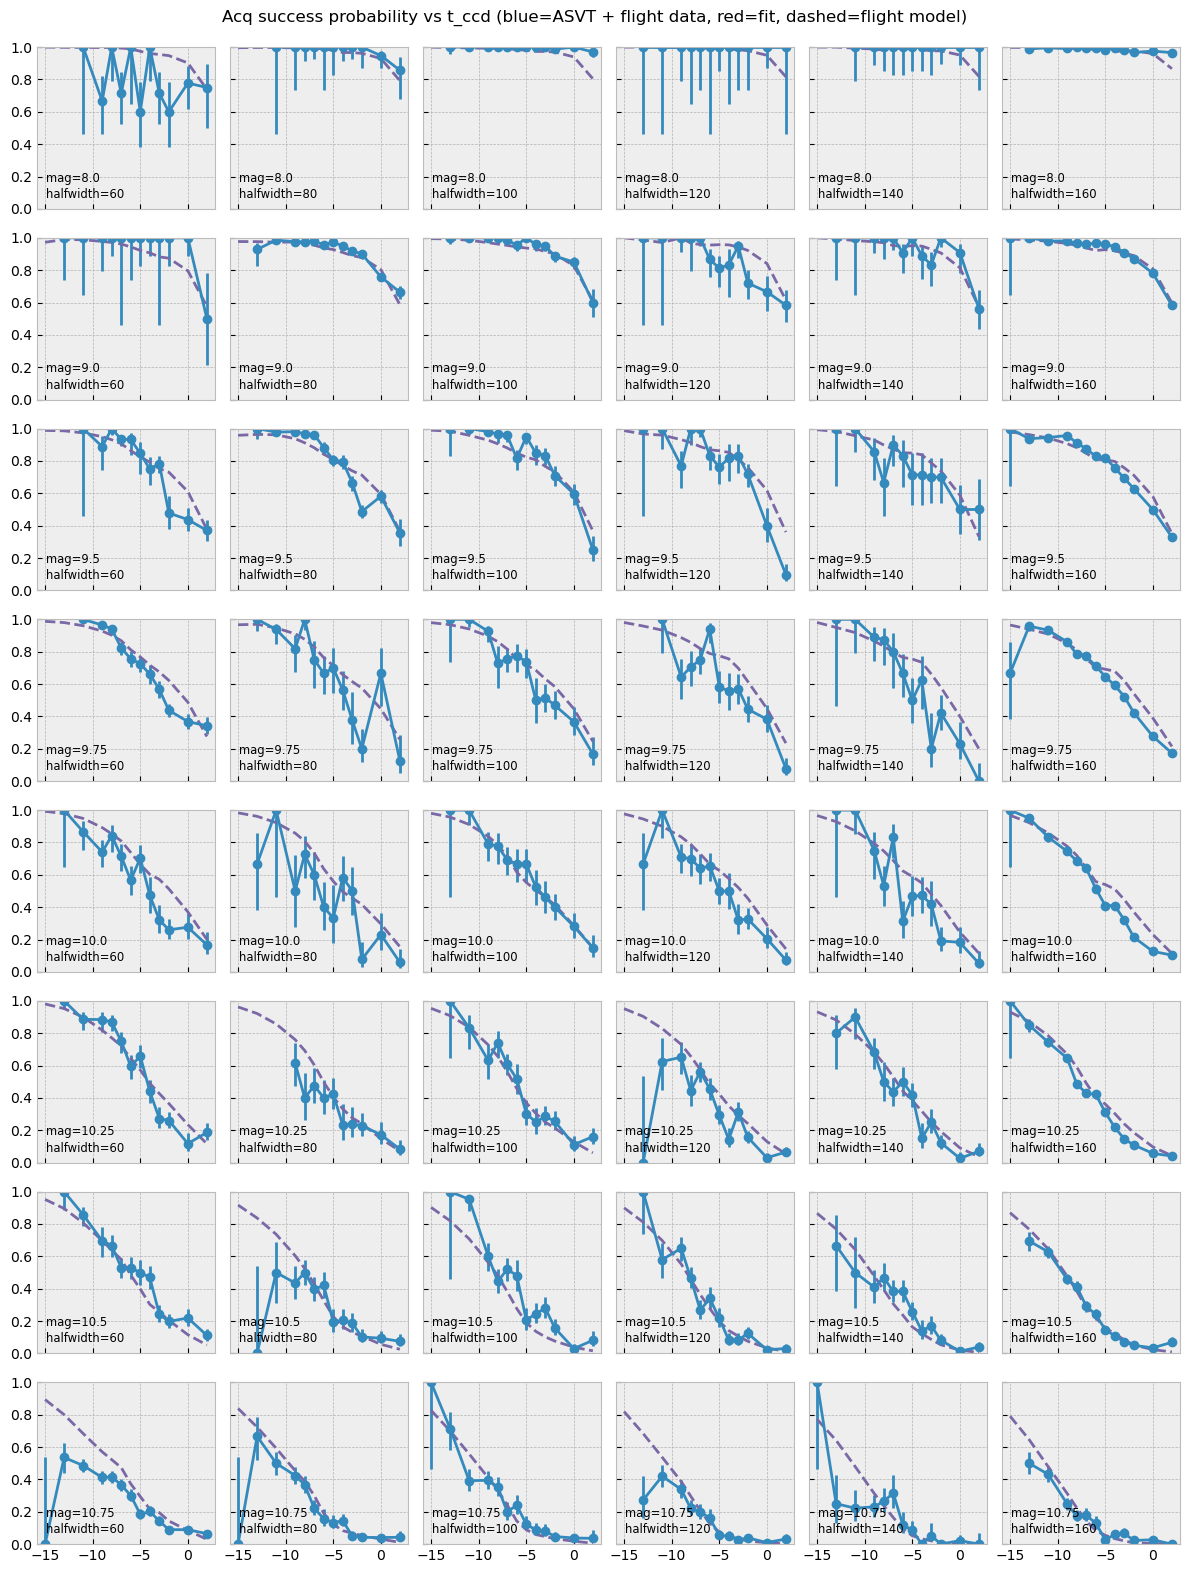

In [34]:
make_plots_grid(x_axis="t_ccd", x_grid="halfwidth", y_grid="mag", plot_p_fit=False)

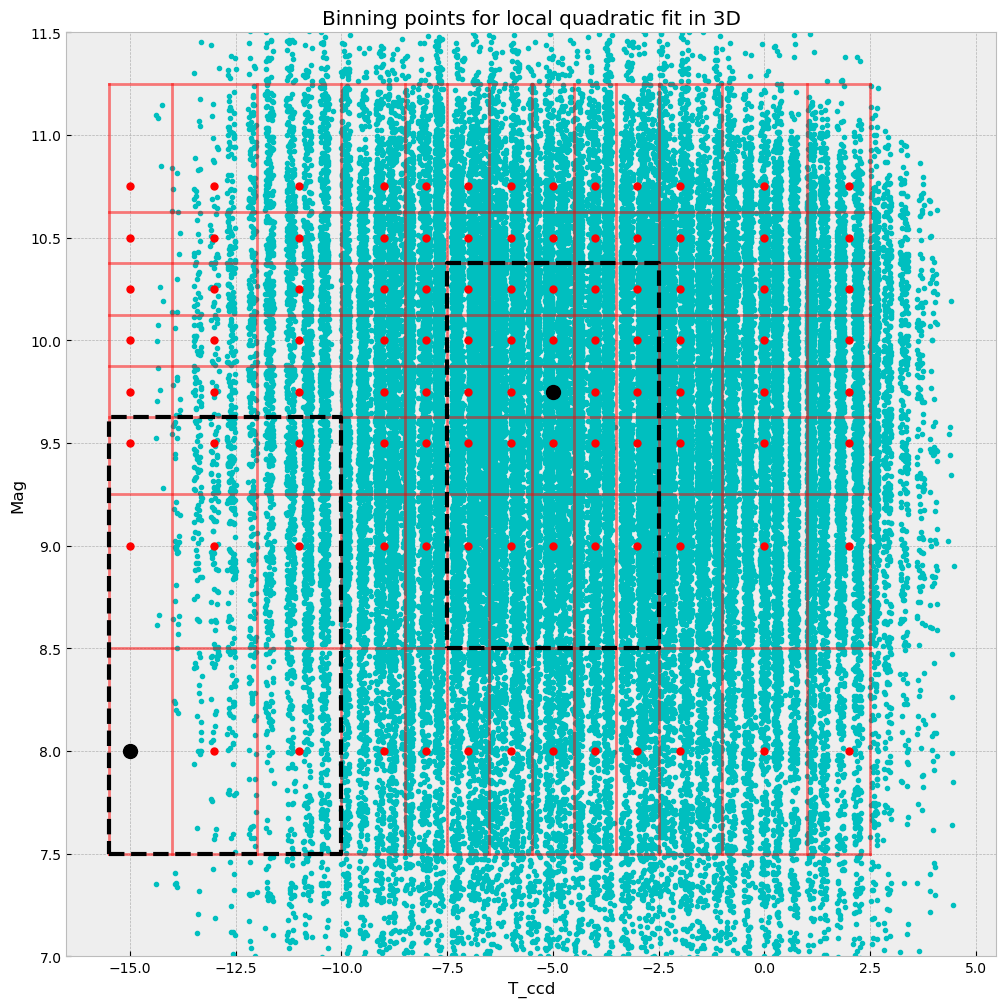

In [35]:
x = flt_asvt["t_ccd"] + np.random.uniform(-0.1, 0.1, len(flt_asvt))
y = flt_asvt["mag_aca"] + np.random.uniform(-0.05, 0.05, len(flt_asvt))
plt.figure(figsize=(12, 12))
plt.plot(x, y, ".", color="c")
plt.ylim(7.0, 11.5)
for mag in mag_bins:
    plt.plot([t_ccd_bins[0], t_ccd_bins[-1]], [mag, mag], color="r", alpha=0.5)
for t_ccd in t_ccd_bins:
    plt.plot([t_ccd, t_ccd], [mag_bins[0], mag_bins[-1]], color="r", alpha=0.5)

x, y = np.meshgrid(t_ccd_vals, mag_vals, indexing="ij")
plt.plot(x, y, "o", color="r", markersize=5)

# CoPilot note:
# I typed: "plt.plot([-15.5, -10, -10,"" and CoPilot gave the rest with small corrections
plt.plot(
    [-15.5, -10, -10, -15.5, -15.5],
    [7.5, 7.5, 9.625, 9.625, 7.5],
    "--",
    color="k",
    lw=3,
)
plt.plot(
    [-7.5, -2.5, -2.5, -7.5, -7.5],
    [8.5, 8.5, 10.375, 10.375, 8.5],
    "--",
    color="k",
    lw=3,
)
plt.plot([-15, -5], [8.0, 9.75], "o", color="k", markersize=10)

plt.xlabel("T_ccd")
plt.ylabel("Mag")
plt.title("Binning points for local quadratic fit in 3D");

In [36]:
def as_table(arr, fmt=None):
    """Turn one of the summary arrays into a readable table"""
    t = Table()
    t["mag"] = [str(val) for val in mag_vals]
    names = [f"{t_ccd:.1f}" for t_ccd in t_ccd_vals]
    for jj, name in enumerate(names):
        t[name] = arr[:, jj]
        if fmt:
            t[name].info.format = fmt
    return t

In [37]:
as_table(n_samp[:, :, 3])

mag,-15.0,-13.0,-11.0,-9.0,-8.0,-7.0,-6.0,-5.0,-4.0,-3.0,-2.0,0.0,2.0
str5,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
8.0,0,1,1,4,2,3,1,6,2,3,3,7,1
9.0,0,1,1,11,4,20,15,16,6,20,25,18,24
9.5,0,1,7,13,9,18,24,21,11,18,39,20,31
9.75,0,0,4,14,17,28,17,24,18,28,36,34,26
10.0,0,3,5,24,20,25,29,40,20,25,52,39,41
10.25,0,1,8,23,27,64,55,58,35,64,96,66,92
10.5,0,3,19,40,58,60,47,51,61,60,81,88,67
10.75,0,11,50,65,77,75,56,74,81,75,103,101,63


In [38]:
as_table(n_samp_flt[:, :, 3])  # 120 arcsec halfwidth

mag,-15.0,-13.0,-11.0,-9.0,-8.0,-7.0,-6.0,-5.0,-4.0,-3.0,-2.0,0.0,2.0
str5,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
8.0,0,9,37,84,71,60,41,27,10,1,0,0,0
9.0,0,21,72,167,192,180,142,143,39,4,0,0,0
9.5,3,15,62,200,185,185,146,127,36,0,0,0,0
9.75,0,10,73,147,122,107,65,51,15,0,0,0,0
10.0,1,20,93,127,95,70,57,42,6,1,0,0,0
10.25,0,13,34,41,25,19,5,12,1,0,0,0,0
10.5,0,6,12,19,18,7,2,1,1,0,0,0,0
10.75,0,0,6,7,5,3,0,0,0,0,0,0,0


In [39]:
as_table((n_samp_flt - n_succ_flt)[:, :, 3])  # 120 arcsec halfwidth

mag,-15.0,-13.0,-11.0,-9.0,-8.0,-7.0,-6.0,-5.0,-4.0,-3.0,-2.0,0.0,2.0
str5,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
8.0,0,0,1,2,1,0,2,0,0,0,0,0,0
9.0,0,0,1,7,16,8,4,6,2,1,0,0,0
9.5,0,0,7,21,15,18,20,19,13,0,0,0,0
9.75,0,0,6,12,14,28,16,16,5,0,0,0,0
10.0,0,2,9,12,23,19,18,15,2,1,0,0,0
10.25,0,1,5,7,6,8,2,7,1,0,0,0,0
10.5,0,0,3,3,3,4,2,1,0,0,0,0,0
10.75,0,0,2,6,5,3,0,0,0,0,0,0,0


In [40]:
as_table(
    1 - n_succ_flt[:, :, 3] / n_samp_flt[:, :, 3], fmt=".2f"
)  # 120 arcsec halfwidth

/var/folders/0p/mj5zm2311gl283lksrknl7bc0000gp/T/ipykernel_45141/3825865565.py:2: RuntimeWarning: invalid value encountered in divide
  1 - n_succ_flt[:, :, 3] / n_samp_flt[:, :, 3], fmt=".2f"


mag,-15.0,-13.0,-11.0,-9.0,-8.0,-7.0,-6.0,-5.0,-4.0,-3.0,-2.0,0.0,2.0
str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
8.0,nan,0.00,0.03,0.02,0.01,0.00,0.05,0.00,0.00,0.00,nan,nan,nan
9.0,nan,0.00,0.01,0.04,0.08,0.04,0.03,0.04,0.05,0.25,nan,nan,nan
9.5,0.00,0.00,0.11,0.10,0.08,0.10,0.14,0.15,0.36,nan,nan,nan,nan
9.75,nan,0.00,0.08,0.08,0.11,0.26,0.25,0.31,0.33,nan,nan,nan,nan
10.0,0.00,0.10,0.10,0.09,0.24,0.27,0.32,0.36,0.33,1.00,nan,nan,nan
10.25,nan,0.08,0.15,0.17,0.24,0.42,0.40,0.58,1.00,nan,nan,nan,nan
10.5,nan,0.00,0.25,0.16,0.17,0.57,1.00,1.00,0.00,nan,nan,nan,nan
10.75,nan,nan,0.33,0.86,1.00,1.00,nan,nan,nan,nan,nan,nan,nan


In [41]:
as_table(
    1 - n_succ_asvt[:, :, 3] / n_samp_asvt[:, :, 3], fmt=".2f"
)  # 120 arcsec halfwidth

/var/folders/0p/mj5zm2311gl283lksrknl7bc0000gp/T/ipykernel_45141/3568557977.py:2: RuntimeWarning: invalid value encountered in divide
  1 - n_succ_asvt[:, :, 3] / n_samp_asvt[:, :, 3], fmt=".2f"


mag,-15.0,-13.0,-11.0,-9.0,-8.0,-7.0,-6.0,-5.0,-4.0,-3.0,-2.0,0.0,2.0
str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
8.0,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9.0,nan,0.00,0.00,0.00,0.00,0.00,0.13,0.19,0.17,0.05,0.28,0.33,0.42
9.5,nan,0.00,0.00,0.23,0.00,0.00,0.17,0.24,0.18,0.17,0.28,0.60,0.90
9.75,nan,nan,0.00,0.36,0.29,0.25,0.06,0.42,0.44,0.43,0.56,0.62,0.92
10.0,nan,0.33,0.00,0.29,0.30,0.36,0.34,0.50,0.50,0.68,0.67,0.79,0.93
10.25,nan,1.00,0.38,0.35,0.56,0.44,0.55,0.71,0.86,0.69,0.84,0.97,0.93
10.5,nan,0.00,0.42,0.35,0.53,0.73,0.66,0.78,0.92,0.92,0.88,0.98,0.97
10.75,nan,0.73,0.58,0.66,0.78,0.80,0.84,0.95,0.95,0.97,0.96,0.99,0.97


In [42]:
as_table(1 - p_succ_flt[:, :, 3], fmt=".2f")  # 120 arcsec halfwidth

mag,-15.0,-13.0,-11.0,-9.0,-8.0,-7.0,-6.0,-5.0,-4.0,-3.0,-2.0,0.0,2.0
str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
8.0,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0.02,0.02,0.05,0.18
9.0,0.00,0.01,0.03,0.00,0.03,0.04,0.04,0.04,0.04,0.06,0.08,0.16,0.38
9.5,0.01,0.03,0.04,0.07,0.09,0.11,0.13,0.14,0.15,0.19,0.24,0.38,0.64
9.75,0.02,0.04,0.07,0.11,0.14,0.18,0.21,0.23,0.24,0.30,0.38,0.55,0.77
10.0,0.02,0.05,0.10,0.17,0.21,0.27,0.33,0.37,0.42,0.48,0.55,0.71,0.86
10.25,0.05,0.10,0.17,0.27,0.34,0.42,0.52,0.58,0.65,0.71,0.76,0.87,0.95
10.5,0.10,0.19,0.30,0.45,0.54,0.64,0.72,0.80,0.86,0.89,0.93,0.97,0.99
10.75,0.18,0.32,0.46,0.61,0.70,0.79,0.87,0.92,0.95,0.97,0.98,0.99,1.00


In [43]:
def get_successes_slice(
    dat: Table,
    mag0=None,
    mag1=None,
    t_ccd0=None,
    t_ccd1=None,
    halfwidth0=None,
    halfwidth1=None,
):
    """Return a slice of the acq stats data table with the specified ranges."""
    ok = np.ones_like(dat["mag_aca"], dtype=bool)
    if mag0 is not None:
        ok &= dat["mag_aca"] >= mag0
    if mag1 is not None:
        ok &= dat["mag_aca"] < mag1
    if t_ccd0 is not None:
        ok &= dat["t_ccd"] >= t_ccd0
    if t_ccd1 is not None:
        ok &= dat["t_ccd"] < t_ccd1
    if halfwidth0 is not None:
        ok &= dat["halfwidth"] >= halfwidth0
    if halfwidth1 is not None:
        ok &= dat["halfwidth"] < halfwidth1
    return dat[ok]

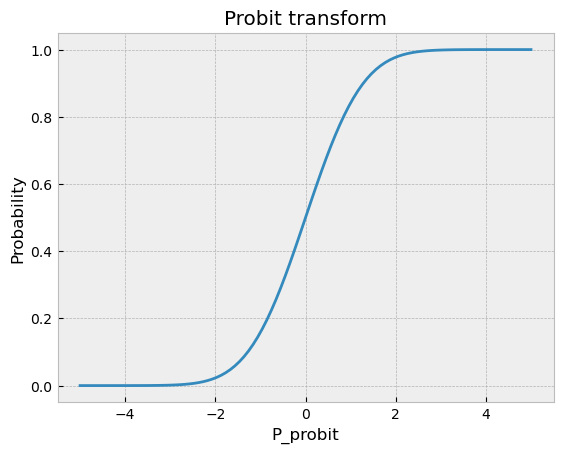

In [44]:
x = np.linspace(-5, 5, 100)
plt.plot(x, stats.norm.cdf(x))
plt.xlabel("P_probit")
plt.ylabel("Probability")
plt.title("Probit transform");

In [45]:
def calc_p_succ(pars, xs, x0s, order, as_probit=False):
    """
    Binomial probability model for N-d data

    Quadratic fit is of the form::

        dx0 = xs[0, :] - x0s[0]
        ...
        dxN-1 = xs[N-1, :] - x0s[N-1]
        p_probit = p0 * dx0 + p1 * dx0**2 + ... + p(2N+1)

    Parameters
    ----------

    pars : array-like
        Model parameters.  The last element is the intercept p(2N+1) and the previous 2N
        are the linear and quadratic coefficients for each of the N dimensions.
    xs : N x M array-like
        M data points in N dimensions
    x0s : N array-like
        Reference point for each dimension
    order : int
        Order of the polynomial fit.  Must be 1 or 2.
    as_probit : bool
        If True then return the probit probability.  If False then return probability.

    Returns
    -------
    prob : M array-like
        Probability of success for each of the M data points
    """
    xs = np.asarray(xs)
    x0s = np.asarray(x0s)

    p_succ_probit = pars[-1] * np.ones(shape=xs.shape[1:])

    for ii in range(len(x0s)):
        dx = xs[ii, ...] - x0s[ii]
        if order == 1:
            p_succ_probit[...] += pars[ii] * dx
        elif order == 2:
            p_succ_probit[...] += pars[2 * ii] * dx + pars[2 * ii + 1] * dx**2
        else:
            raise ValueError(f"order={order} not supported")

    # Transform from probit to linear probability if user requested
    out = p_succ_probit if as_probit else stats.norm.cdf(p_succ_probit)

    return out

In [46]:
def calc_binom_stat(succ, p_succ):
    """
    Calculate log-likelihood for a binomial probability distribution.

    Defining p = model, then probability of seeing data == 1 is p and probability of
    seeing data == 0 is (1 - p). Probability of seeing the entire data set is the
    product of the probabilities of each data point.

    Note here that ``data`` is strictly either 0.0 or 1.0, and np.where interprets those
    float values as False or True respectively.

    Parameters
    ----------
    succ : array-like
        Array of successes (True or 1) or failures (False or 0)
    p_succ : array-like (same shape as ``succ``)
        Array of probabilities of success
    """
    bad = (p_succ < 0) | (p_succ > 1)
    if np.any(bad):
        raise ValueError(f"p_succ must be in the range 0 to 1 (got {p_succ[bad]})")
    # Clip to avoid log(0). Large probit values can result in p_succ = 1.0
    p_succ = p_succ.clip(1e-8, 1 - 1e-8)

    fit_stat = -np.sum(np.log(np.where(succ, p_succ, 1.0 - p_succ)))

    return fit_stat

In [47]:
def calc_fit_stat(pars, xs, x0s, succ, order):
    """Fitting statistic function for binomial probability model"""
    p_succ = calc_p_succ(pars, xs, x0s, order)
    fit_stat = calc_binom_stat(succ, p_succ)
    return fit_stat

## Example binomial fitting

In [48]:
xs = [np.random.uniform(0, 3, size=1000)]
x0s = [1.5]
pars = [1, 0.25]

In [49]:
p_succ = calc_p_succ(pars, xs, x0s, order=1)

In [50]:
succ = np.random.uniform(size=p_succ.shape) < p_succ

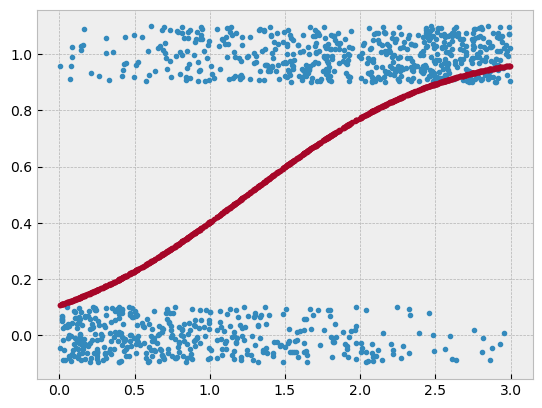

In [51]:
plt.plot(xs[0], succ + np.random.uniform(-0.1, 0.1, size=1000), ".")
plt.plot(xs[0], p_succ, ".");

In [52]:
calc_fit_stat(pars, xs, x0s, succ, order=1)

488.19275043240384

In [53]:
calc_fit_stat([1, 1.0], xs, x0s, succ, order=1)

619.963239889799

In [54]:
%time optimize.minimize(calc_fit_stat, [0.0, 0.0], args=(xs, x0s, succ, 1))

CPU times: user 3.49 ms, sys: 1.08 ms, total: 4.57 ms
Wall time: 4.08 ms


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 487.913119016906
        x: [ 1.044e+00  2.560e-01]
      nit: 6
      jac: [ 0.000e+00 -3.815e-06]
 hess_inv: [[ 3.515e-03  4.176e-04]
            [ 4.176e-04  2.121e-03]]
     nfev: 27
     njev: 9

In [55]:
dok = get_successes_slice(
    flt_asvt,
    mag0=10.125,
    mag1=10.375,
    t_ccd0=-10,
    t_ccd1=-5,
    halfwidth0=55,
    halfwidth1=65,
)

In [56]:
np.mean(dok["obc_id"])

0.7619047619047619

In [57]:
len(dok)

189

In [58]:
%%time
xs = [dok["mag_aca"], dok["t_ccd"]]
x0s = [8.0, -14.0]
res = optimize.minimize(
    calc_fit_stat, [0.0, 0.0, 0.0], args=(xs, x0s, dok["obc_id"], 1)
)
res

CPU times: user 10.5 ms, sys: 2.89 ms, total: 13.4 ms
Wall time: 16.6 ms


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 98.00629589131347
        x: [-2.531e+00 -2.472e-01  8.133e+00]
      nit: 12
      jac: [ 0.000e+00 -3.815e-06  0.000e+00]
 hess_inv: [[ 2.556e+00 -5.494e-03 -5.681e+00]
            [-5.494e-03  7.329e-03 -4.082e-02]
            [-5.681e+00 -4.082e-02  1.302e+01]]
     nfev: 60
     njev: 15

In [59]:
from itertools import count

In [60]:
def iterbins(bin_edges, width, include_idxs=False):
    """
    Centers:     0   1   2   3   4   5   6   7   8   9
    Edges:     0   1   2   3   4   5   6   7   8   9   10
    width=1 answers:
       (0, 2), (0, 3), (1, 4) ...
    """
    i_min = 0
    i_max = len(bin_edges) - 1
    for i_center in range(len(bin_edges) - 1):
        i_edge0 = np.clip(i_center - width, i_min, i_max)
        i_edge1 = np.clip(i_center + width + 1, i_min, i_max)
        if include_idxs:
            out = i_center, i_edge0, i_edge1, bin_edges[i_edge0], bin_edges[i_edge1]
        else:
            out = i_center, bin_edges[i_edge0], bin_edges[i_edge1]
        yield out

In [61]:
print(mag_bins)
rows = []
for i_center, i_mag0, i_mag1, mag0, mag1 in iterbins(mag_bins, 2, include_idxs=True):
    rows.append((i_center, i_mag0, i_mag1, mag0, mag_vals[i_center], mag1))
t = Table(
    rows=rows, names=["i_center", "i_mag0", "i_mag1", "mag0", "mag_center", "mag1"]
)
t

[ 7.5    8.5    9.25   9.625  9.875 10.125 10.375 10.625 11.25 ]


i_center,i_mag0,i_mag1,mag0,mag_center,mag1
int64,int64,int64,float64,float64,float64
0,0,3,7.5,8.0,9.625
1,0,4,7.5,9.0,9.875
2,0,5,7.5,9.5,10.125
3,1,6,8.5,9.75,10.375
4,2,7,9.25,10.0,10.625
5,3,8,9.625,10.25,11.25
6,4,8,9.875,10.5,11.25
7,5,8,10.125,10.75,11.25


In [62]:
n_succ.size

624

In [63]:
print(mag_vals)
print(mag_bins)

[ 8.    9.    9.5   9.75 10.   10.25 10.5  10.75]
[ 7.5    8.5    9.25   9.625  9.875 10.125 10.375 10.625 11.25 ]


In [64]:
def calc_local_quadratic_fit():
    """
    Calculate a local quadratic fit for each bin in the mag, t_ccd, halfwidth

    Quadratic fit is of the form::

        p0 * (mag - mag0) + p1 * (mag - mag0)**2
        + p2 * (t_ccd - t_ccd0) + p3 * (t_ccd - t_ccd0)**2
        + p4 * (halfwidth - halfwidth0) + p5 * (halfwidth - halfwidth0)**2
        + p6

    Returns a tuple of:
    - p_fit_probit (model fit success as probit):
        3D array of shape (n_mag, n_t_ccd, n_halfwidth)
    - P_succ (data success as probability):
        3D array of shape (n_mag, n_t_ccd, n_halfwidth)

    (NOTE: CoPilot wrote most of this docstring)
    """
    p_fit_probit = np.zeros(shape=n_succ.shape, dtype=float)
    p_succ = np.zeros_like(p_fit_probit)

    for i_mag, mag0, mag1 in iterbins(mag_bins, width=2):
        mag = mag_vals[i_mag]
        print(f"{mag=} {i_mag=} ({mag0} to {mag1})")

        for i_t_ccd, t_ccd0, t_ccd1 in iterbins(t_ccd_bins, width=2):
            t_ccd = t_ccd_vals[i_t_ccd]

            for i_halfwidth, halfwidth0, halfwidth1 in iterbins(
                halfwidth_bins, width=2
            ):
                halfwidth = halfwidth_vals[i_halfwidth]
                # print(f"{halfwidth=} {i_halfwidth=} ({halfwidth0} to {halfwidth1})")
                dok = get_successes_slice(
                    flt_asvt,
                    mag0=mag0,
                    mag1=mag1,
                    t_ccd0=t_ccd0,
                    t_ccd1=t_ccd1,
                    halfwidth0=halfwidth0,
                    halfwidth1=halfwidth1,
                )
                xs = [dok["mag_aca"], dok["t_ccd"], dok["halfwidth"]]
                x0s = [mag, t_ccd, halfwidth]
                x_init = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
                res = optimize.minimize(
                    calc_fit_stat,
                    x_init,
                    args=(xs, x0s, dok["obc_id"], 2),
                )
                p_succ0 = np.count_nonzero(dok["obc_id"]) / len(dok)
                p_fit_probit[i_mag, i_t_ccd, i_halfwidth] = res.x[-1]
                p_succ[i_mag, i_t_ccd, i_halfwidth] = p_succ0

    return p_fit_probit, p_succ

In [65]:
# 1m48s on x86_64
# 1m26s on ARM
path = Path("p_fit_probit_2024.npz")
if not path.exists():
    p_fit_probit, p_succ = calc_local_quadratic_fit()
    # CoPilot note:
    # Entered "np.savez" and CoPilot got the rest
    np.savez(path, p_fit_probit=p_fit_probit, p_succ=p_succ)
else:
    # CoPilot note:
    # Wote "with" and CoPilot wrote the rest
    with np.load(path) as data:
        p_fit_probit = data["p_fit_probit"]
        p_succ = data["p_succ"]

In [66]:
p_fit = stats.norm.cdf(p_fit_probit)

In [67]:
# Print p_fit for mag_aca=10.75. Cols are halfwidth, rows are t_ccd
p_fit_probit[-1, :, :].round(3)

array([[ 1.293,  1.019,  0.954,  0.939,  0.76 ,  0.851],
       [ 0.906,  0.633,  0.547,  0.478,  0.359,  0.386],
       [ 0.527,  0.29 ,  0.192,  0.1  , -0.051, -0.021],
       [ 0.199, -0.059, -0.173, -0.27 , -0.464, -0.425],
       [ 0.055, -0.239, -0.379, -0.515, -0.69 , -0.694],
       [-0.129, -0.531, -0.693, -0.853, -0.985, -1.047],
       [-0.403, -0.89 , -1.064, -1.175, -1.336, -1.358],
       [-0.598, -1.167, -1.342, -1.446, -1.611, -1.556],
       [-0.811, -1.382, -1.556, -1.703, -1.831, -1.796],
       [-0.873, -1.492, -1.668, -1.827, -2.051, -2.035],
       [-1.065, -1.608, -1.831, -2.075, -2.406, -2.425],
       [-1.376, -1.864, -2.095, -2.369, -2.835, -2.694],
       [-1.882, -2.287, -2.519, -2.926, -3.666, -3.345]])

In [68]:
# Print p_fit for mag_aca=10.75. Cols are halfwidth, rows are t_ccd
p_fit[-1, :, :].round(3)

array([[0.902, 0.846, 0.83 , 0.826, 0.776, 0.803],
       [0.817, 0.737, 0.708, 0.684, 0.64 , 0.65 ],
       [0.701, 0.614, 0.576, 0.54 , 0.48 , 0.492],
       [0.579, 0.477, 0.431, 0.394, 0.321, 0.335],
       [0.522, 0.406, 0.352, 0.303, 0.245, 0.244],
       [0.449, 0.298, 0.244, 0.197, 0.162, 0.148],
       [0.344, 0.187, 0.144, 0.12 , 0.091, 0.087],
       [0.275, 0.122, 0.09 , 0.074, 0.054, 0.06 ],
       [0.209, 0.083, 0.06 , 0.044, 0.034, 0.036],
       [0.191, 0.068, 0.048, 0.034, 0.02 , 0.021],
       [0.143, 0.054, 0.034, 0.019, 0.008, 0.008],
       [0.084, 0.031, 0.018, 0.009, 0.002, 0.004],
       [0.03 , 0.011, 0.006, 0.002, 0.   , 0.   ]])

In [69]:
(1 - p_succ[2]).round(3)

array([[0.022, 0.027, 0.027, 0.03 , 0.03 , 0.031],
       [0.033, 0.038, 0.039, 0.037, 0.037, 0.037],
       [0.042, 0.048, 0.049, 0.043, 0.043, 0.043],
       [0.053, 0.06 , 0.062, 0.048, 0.047, 0.047],
       [0.065, 0.073, 0.075, 0.053, 0.052, 0.052],
       [0.086, 0.093, 0.096, 0.063, 0.062, 0.06 ],
       [0.116, 0.121, 0.122, 0.08 , 0.077, 0.074],
       [0.15 , 0.152, 0.152, 0.101, 0.095, 0.092],
       [0.2  , 0.195, 0.193, 0.138, 0.126, 0.122],
       [0.251, 0.246, 0.243, 0.191, 0.175, 0.169],
       [0.333, 0.33 , 0.329, 0.309, 0.294, 0.293],
       [0.369, 0.369, 0.37 , 0.371, 0.364, 0.37 ],
       [0.409, 0.409, 0.413, 0.415, 0.411, 0.415]])

In [70]:
len(flt_asvt)

69024

In [71]:
AXIS_LABELS = ["mag", "t_ccd", "halfwidth"]
X_VALS = [mag_vals, t_ccd_vals, halfwidth_vals]

In [72]:
p_succ_flt.shape

(8, 13, 6)

In [73]:
p_fit.shape

(8, 13, 6)

/var/folders/0p/mj5zm2311gl283lksrknl7bc0000gp/T/ipykernel_45141/804818365.py:38: RuntimeWarning: invalid value encountered in scalar divide
  p = k / n
/var/folders/0p/mj5zm2311gl283lksrknl7bc0000gp/T/ipykernel_45141/804818365.py:38: RuntimeWarning: invalid value encountered in scalar divide
  p = k / n
/var/folders/0p/mj5zm2311gl283lksrknl7bc0000gp/T/ipykernel_45141/804818365.py:38: RuntimeWarning: invalid value encountered in scalar divide
  p = k / n
/var/folders/0p/mj5zm2311gl283lksrknl7bc0000gp/T/ipykernel_45141/804818365.py:38: RuntimeWarning: invalid value encountered in scalar divide
  p = k / n
/var/folders/0p/mj5zm2311gl283lksrknl7bc0000gp/T/ipykernel_45141/804818365.py:38: RuntimeWarning: invalid value encountered in scalar divide
  p = k / n
/var/folders/0p/mj5zm2311gl283lksrknl7bc0000gp/T/ipykernel_45141/804818365.py:38: RuntimeWarning: invalid value encountered in scalar divide
  p = k / n
/var/folders/0p/mj5zm2311gl283lksrknl7bc0000gp/T/ipykernel_45141/804818365.py:38: 

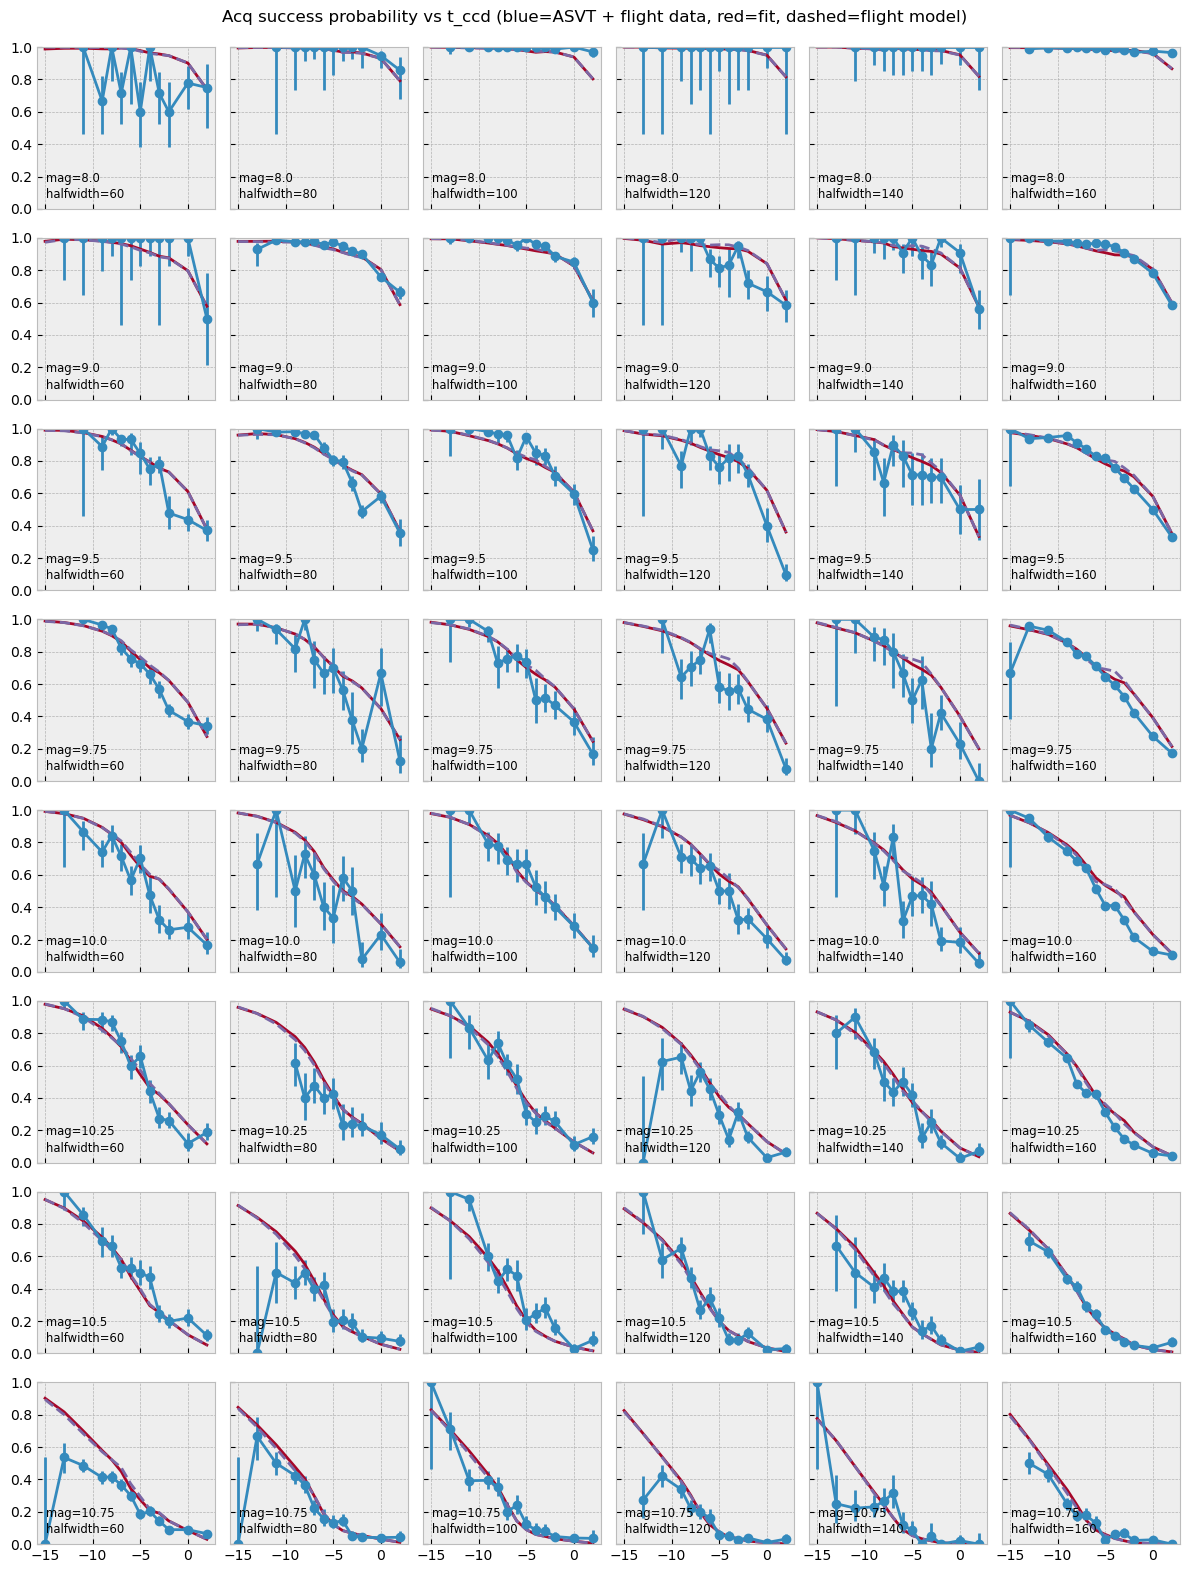

In [74]:
make_plots_grid(x_axis="t_ccd", x_grid="halfwidth", y_grid="mag")

/var/folders/0p/mj5zm2311gl283lksrknl7bc0000gp/T/ipykernel_45141/804818365.py:38: RuntimeWarning: invalid value encountered in scalar divide
  p = k / n
/var/folders/0p/mj5zm2311gl283lksrknl7bc0000gp/T/ipykernel_45141/804818365.py:38: RuntimeWarning: invalid value encountered in scalar divide
  p = k / n
/var/folders/0p/mj5zm2311gl283lksrknl7bc0000gp/T/ipykernel_45141/804818365.py:38: RuntimeWarning: invalid value encountered in scalar divide
  p = k / n
/var/folders/0p/mj5zm2311gl283lksrknl7bc0000gp/T/ipykernel_45141/804818365.py:38: RuntimeWarning: invalid value encountered in scalar divide
  p = k / n
/var/folders/0p/mj5zm2311gl283lksrknl7bc0000gp/T/ipykernel_45141/804818365.py:38: RuntimeWarning: invalid value encountered in scalar divide
  p = k / n
/var/folders/0p/mj5zm2311gl283lksrknl7bc0000gp/T/ipykernel_45141/804818365.py:38: RuntimeWarning: invalid value encountered in scalar divide
  p = k / n
/var/folders/0p/mj5zm2311gl283lksrknl7bc0000gp/T/ipykernel_45141/804818365.py:38: 

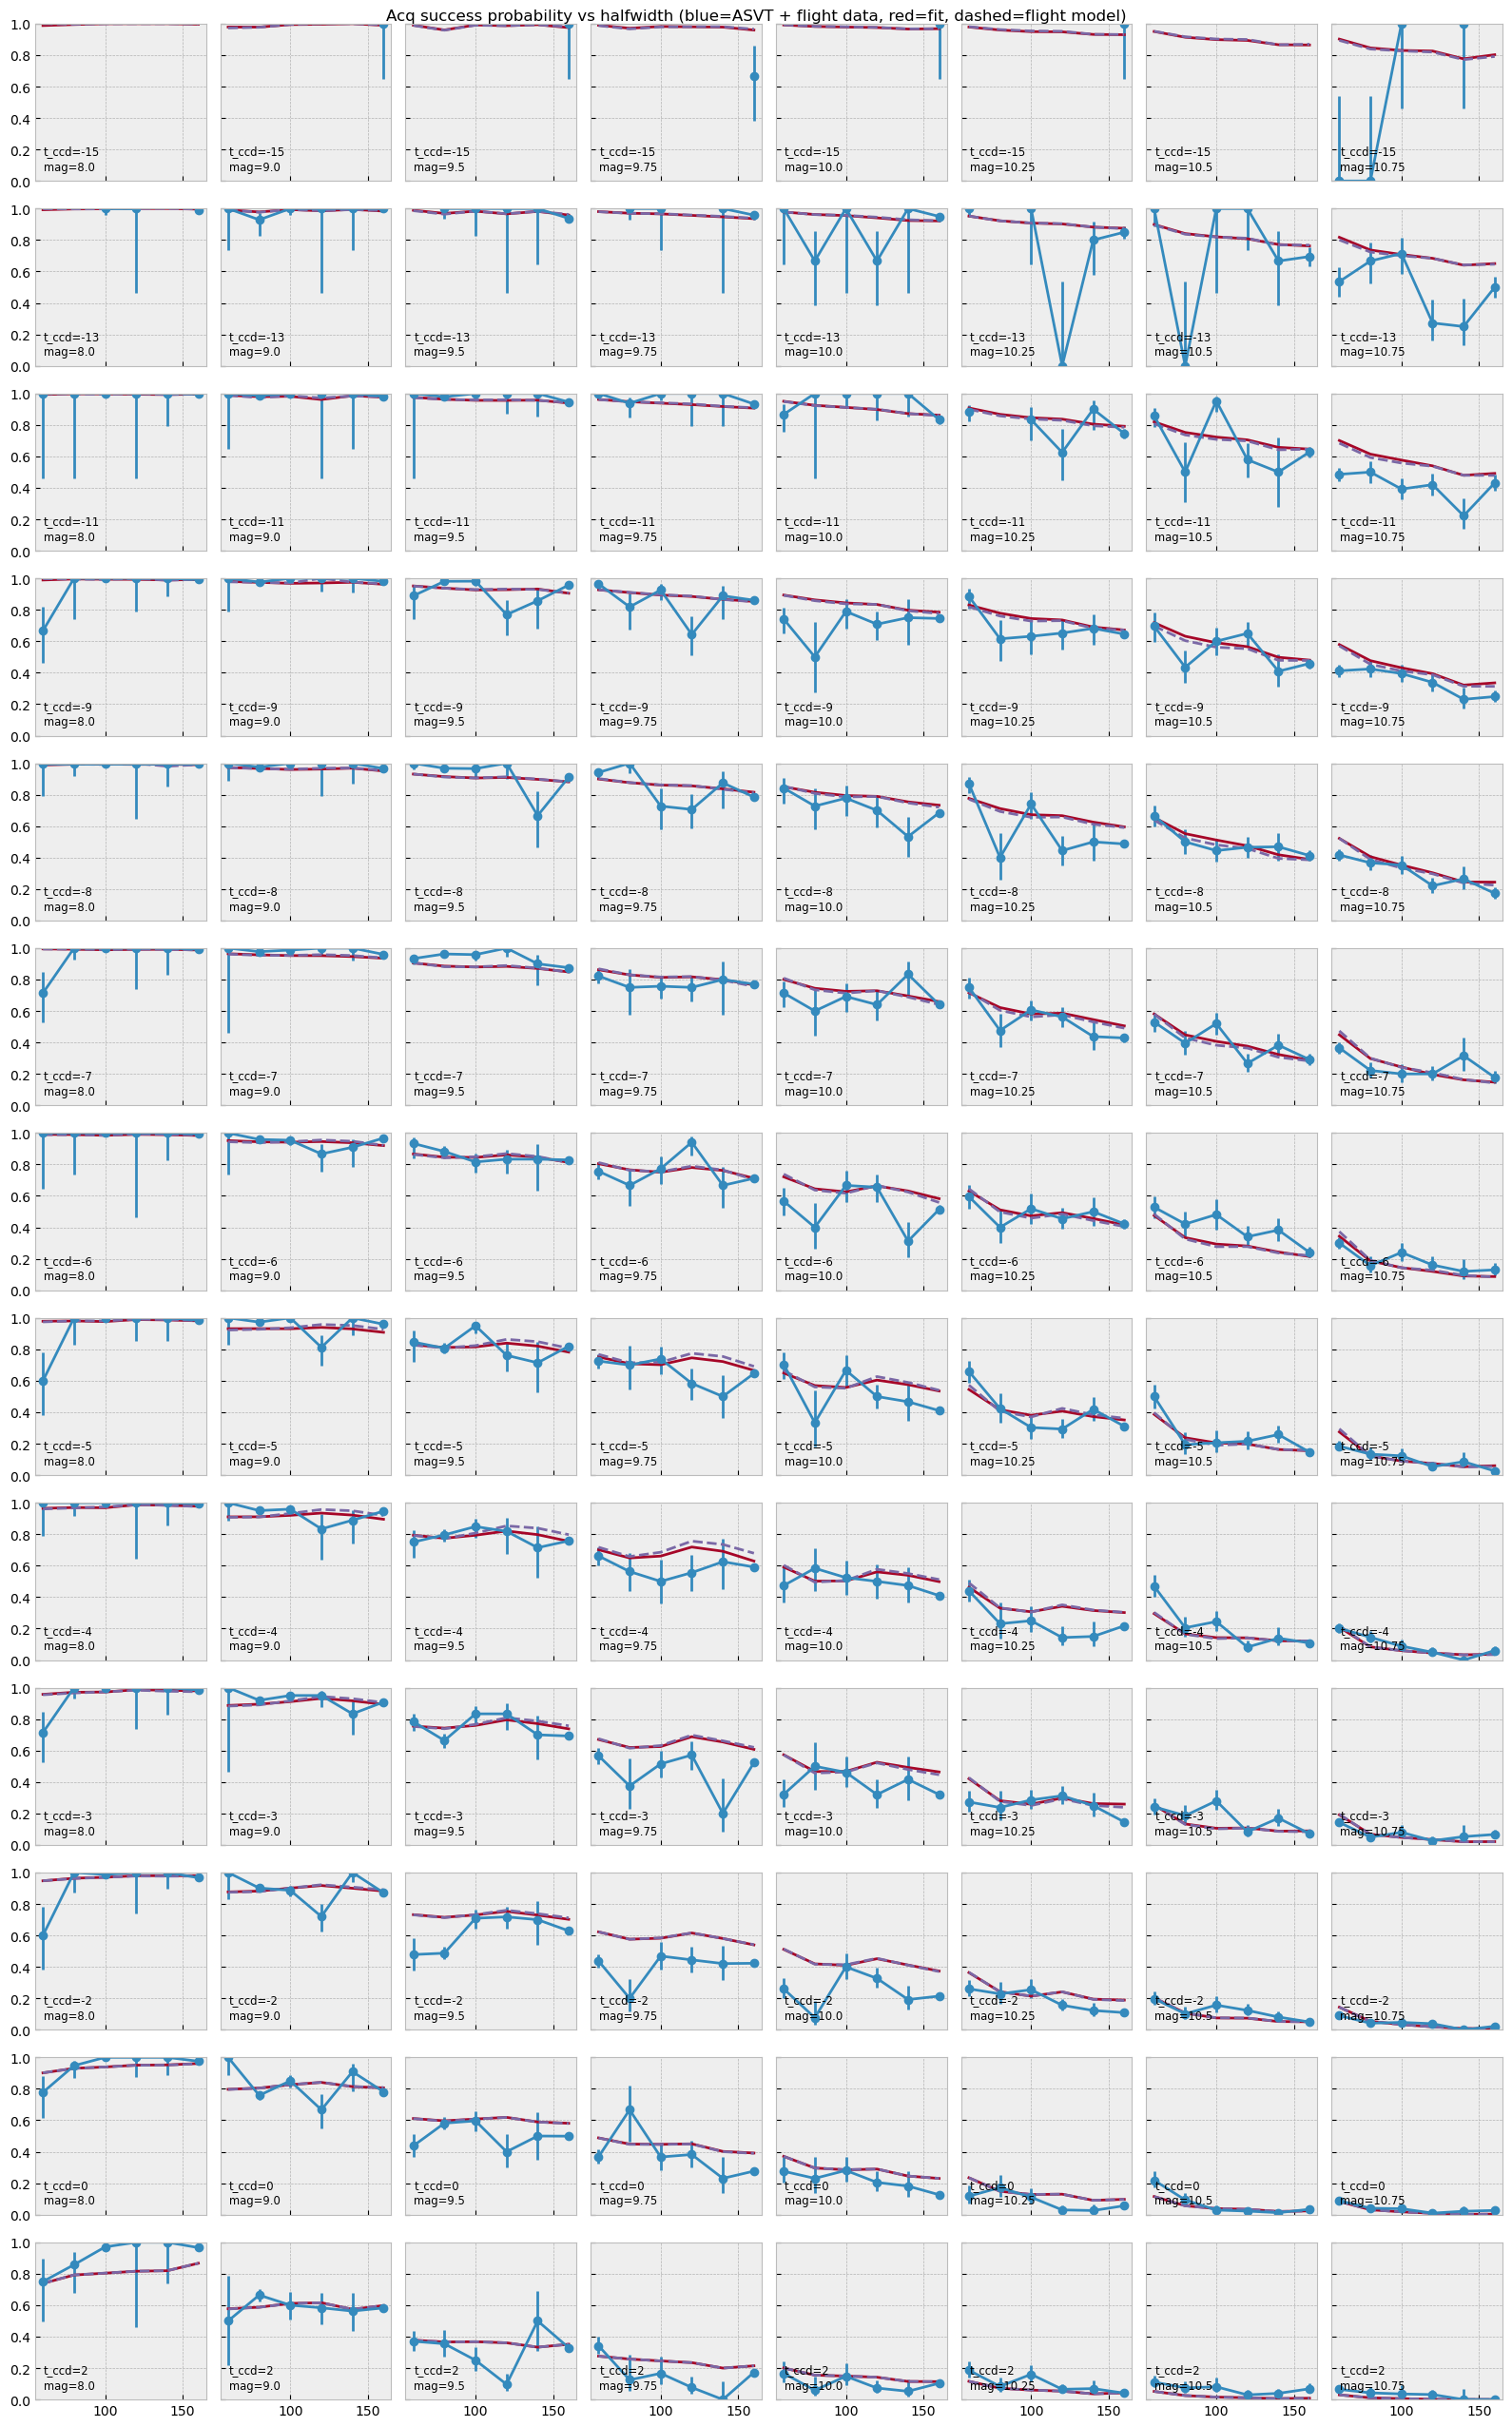

In [75]:
make_plots_grid(x_axis="halfwidth", x_grid="mag", y_grid="t_ccd")

In [76]:
star_probs.acq_success_prob(mag=)

SyntaxError: invalid syntax (629133362.py, line 1)

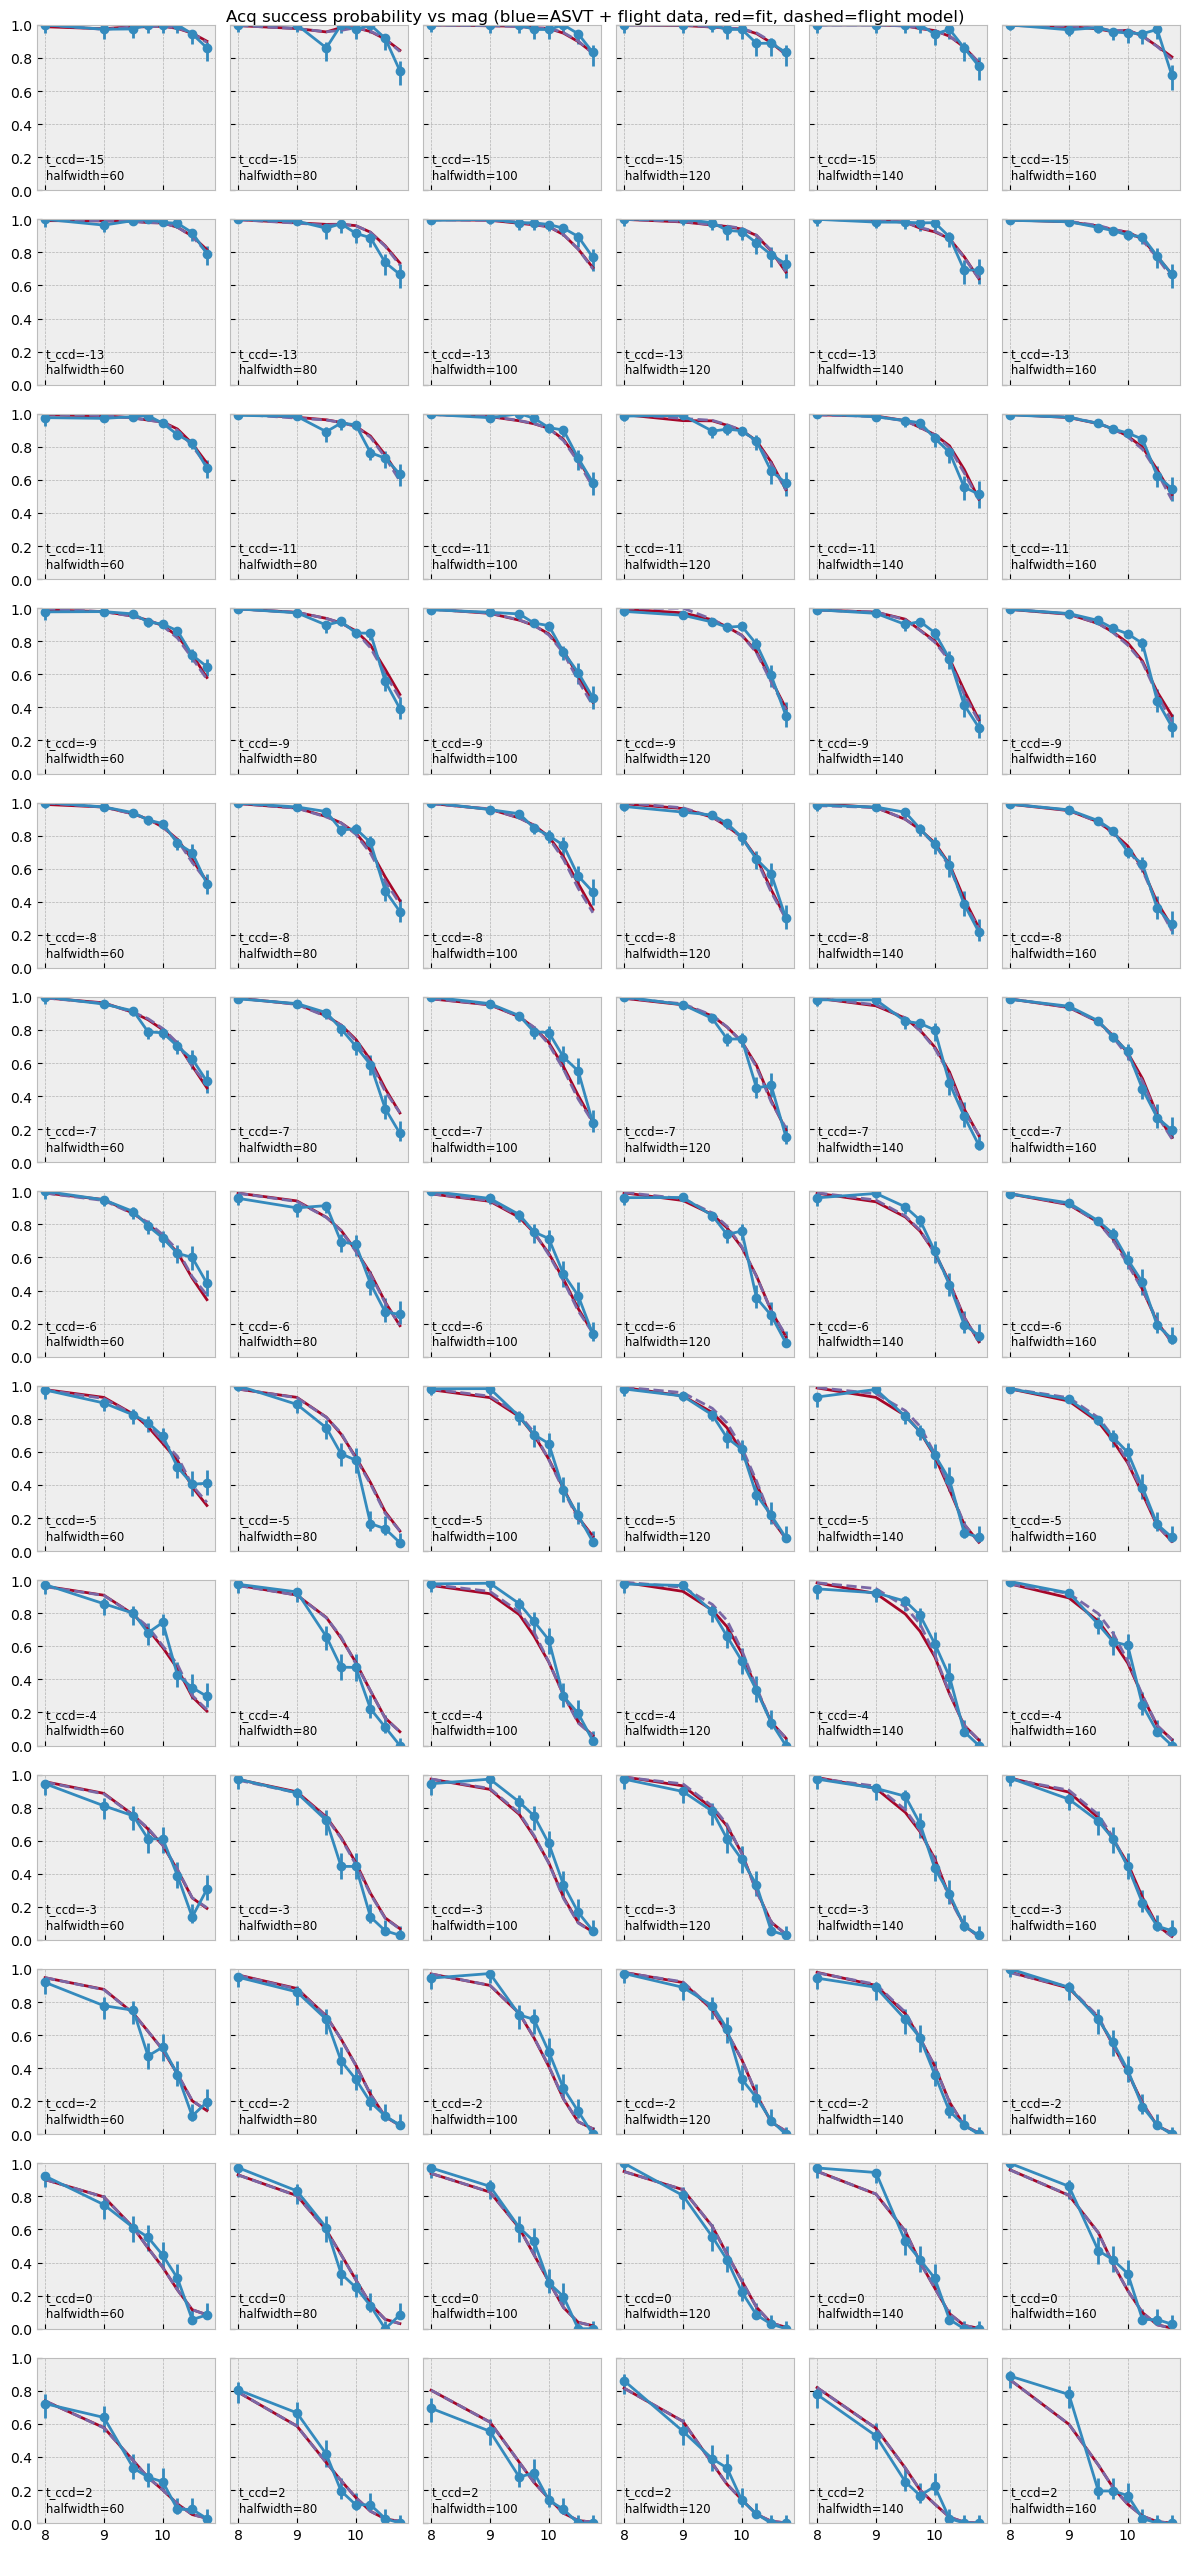

In [ ]:
make_plots_grid(x_axis="mag", x_grid="halfwidth", y_grid="t_ccd")

## Write final model out as FITS in the standard format

In [ ]:
def set_grid_axis_values(hdr, axis, vals):
    """Set grid model axis values for FITS header."""
    hdr[f"{axis}_n"] = len(vals)
    for ii, val in enumerate(vals):
        hdr[f"{axis}_{ii}"] = val
    hdr[f"{axis}_lo"] = vals[0]
    hdr[f"{axis}_hi"] = vals[-1]

In [ ]:
# Succ prob for bright stars
ok = (flt["mag_aca"] > 5.2) & (flt["mag_aca"] < 7.5)
np.mean(flt["obc_id"][ok])

0.9948163173315303

In [ ]:
def add_bright_mags(arr):
    """Update p_succ to add p_succ = 0.993 values for bright mags.

    :param arr: p_succ_probit array
    """
    out = np.full(
        shape=(arr.shape[0] + 2, arr.shape[1], arr.shape[2]),
        fill_value=stats.norm.ppf(0.993),
    )
    out[2:, :, :] = arr
    return out

In [ ]:
def write_model_as_fits(
    model_name,
    p_succ_probit,
    p_succ_1p5_probit,
    mags,
    t_ccds,
    halfws,
    comment=None,
):
    from astropy.io import fits

    # Sampling only goes to mag=8.0, so add bins for mag=5.0 and 7.0 with probability of
    # success of 99.3%. This matches general flight behavior for bright stars.
    mags = np.concatenate([[5.0, 7.0], mags])
    p_succ_probit = add_bright_mags(p_succ_probit)
    p_succ_1p5_probit = add_bright_mags(p_succ_1p5_probit)

    # COLOR not 1.5 (most stars)
    p_fails_probit = -p_succ_probit
    p_fails_1p5_probit = -p_succ_1p5_probit

    hdu = fits.PrimaryHDU()
    # if comment:
    #     hdu.header["comment"] = comment
    hdu.header["date"] = CxoTime().fits
    hdu.header["mdl_name"] = model_name
    set_grid_axis_values(hdu.header, "mag", mags)
    set_grid_axis_values(hdu.header, "t_ccd", t_ccds)
    set_grid_axis_values(hdu.header, "halfw", halfws)

    hdu1 = fits.ImageHDU(p_fails_probit.astype(np.float32))
    hdu1.header["comment"] = "COLOR1 != 1.5 (good mag estimates)"

    hdu2 = fits.ImageHDU(p_fails_1p5_probit.astype(np.float32))
    hdu2.header["comment"] = "COLOR1 == 1.5 (poor mag estimates)"

    hdus = fits.HDUList([hdu, hdu1, hdu2])
    print(f"Writing {model_name}.fits.gz...")
    hdus.writeto(f"{model_name}.fits.gz", overwrite=True)

In [ ]:
comment = f"Created with fit_acq_model-{MODEL_DATE}-local-quadratic.ipynb in aca_stats repository"
write_model_as_fits(
    f"grid-local-quadratic-{MODEL_DATE}",
    p_fit_probit,
    p_fit_probit,  # Use same model for color=1.5 and color!=1.5
    mag_vals,
    t_ccd_vals,
    halfwidth_vals,
    comment=comment,
)

Writing grid-local-quadratic-2024-06.fits.gz...


In [ ]:
!cp grid-local-quadratic-2023-05.fits.gz $SKA/data/chandra_models/chandra_models/aca_acq_prob

In [ ]:
!ls -lrt $SKA/data/chandra_models/chandra_models/aca_acq_prob

total 584
-rw-r--r--  1 aldcroft  staff  144569 Feb 13  2023 grid-floor-2020-02.fits.gz
-rw-r--r--  1 aldcroft  staff  146784 Feb 13  2023 grid-floor-2018-11.fits.gz
-rw-r--r--  1 aldcroft  staff    3113 May 20 15:46 grid-local-quadratic-2023-05.fits.gz


In [ ]:
mags, t_ccds, halfws = np.meshgrid(mag_vals, t_ccd_vals, halfwidth_vals, indexing="ij")

In [ ]:
p_mods = star_probs.acq_success_prob(
    mag=mags, t_ccd=t_ccds, halfwidth=halfws, model="grid-local-quadratic-2023-05"
)

In [ ]:
np.max(np.abs(p_mods - p_fit))

0.04804920236472554